**ATTENTION BASED IMAGE CAPTIONING** 

**IMPORTS**

* re - provides regular expression matching operations 
* os - provides a portable way of using operating system dependent functionality 
* time - provides various time-related functions 
* json - lightweight data interchange format inspired by JavaScript object literal syntax 
* pickle -  module implements binary protocols for serializing and de-serializing a Python object structure 
* random - implements pseudo-random number generators for various distributions. 
* collections - implements specialized container datatypes providing alternatives to Python’s general purpose built-in containers
* numpy -  general-purpose array-processing package 
* tensorflow - open source library for numerical computation and large-scale machine learning 
* matplotlib - comprehensive library for creating static, animated, and interactive visualizations in Python 
* glob - used to retrieve files/pathnames matching a specified pattern 

In [1]:
import re
import os
import time
import json
import pickle
import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

**MS-COCO DATASET**

We use the [MS-COCO dataset](http://cocodataset.org/#home) to build the Attention Model. This dataset is a large-scale object detection,image captioning and segmentation dataset. The dataset contains:


*   82,000 Images
*   5 captions for each image
*   80 object categories
*   250,000 people with key points
*   1.5 million object instances
*   91 stuff categories





**DOWNLOADING AND EXTRACTING THE CAPTIONS AND IMAGE DATA**

The [Annotations](http://images.cocodataset.org/annotations/annotations_trainval2014.zip) consist of the caption files and [Images](http://images.cocodataset.org/zips/train2014.zip) consist of the images of the dataset. 


Downloading the files containing the captions [LINK](http://images.cocodataset.org/annotations/annotations_trainval2014.zip)

---



In [2]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

Download the files containing the images [Images](http://images.cocodataset.org/zips/train2014.zip)

In [3]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                        extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder  

**ALTERING THE SIZE OF THE DATASET**

For this notebook, we are using a total of **30,000 captions**. These captions have corresponding images that will be used for training. We will also experiment with more data and observe if increasing the data will change the model performance.

Loading annotations file

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

NameError: ignored

In [5]:
correspondingCaptionForImage = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  pathToCurrImage = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  correspondingCaptionForImage[pathToCurrImage].append(caption)

For building this model, we select 10,000 images from the shuffled dataset. In the MS COCO dataset, each image has 5 captions. Therefore, we will have 50,000 datapoints.

In [6]:
#generateImagePaths stores the image paths
generateImagePaths = list(correspondingCaptionForImage.keys())
random.shuffle(generateImagePaths)
pathToTrainingImage = generateImagePaths[:6000]
print(len(pathToTrainingImage))

6000



* train_captions - used to store the list of captions 
* image_name_vector - used to store the image path to retrieve the image corresponding to respective caption

In [7]:
#We store the training captions in a list 
storeTrainingCaptions = []
imageEncoded_Details = []

In [8]:
# pathToCurrImage represents the path to a single image
for pathToCurrImage in pathToTrainingImage:
  storeCaptionsSet = correspondingCaptionForImage[pathToCurrImage]
  storeTrainingCaptions.extend(storeCaptionsSet)
  imageEncoded_Details.extend([pathToCurrImage] * len(storeCaptionsSet))

Printing a sample image with its corresponding caption

<start> Small bed near open window with bars in room with wooden floor. <end>


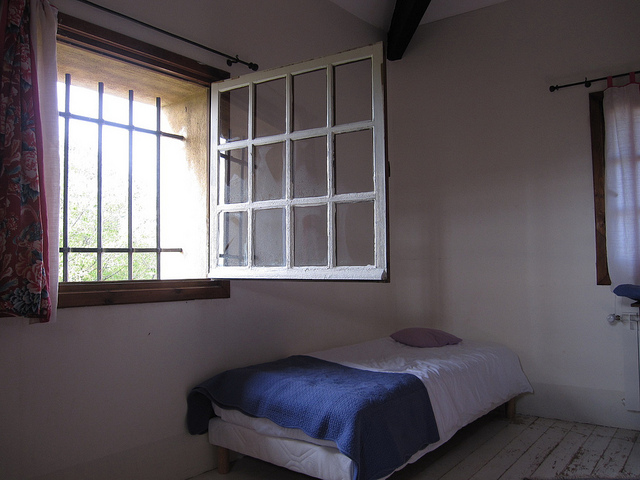

In [9]:
# Printing Sample Image from COCO dataset
print(storeTrainingCaptions[2])
Image.open(imageEncoded_Details[2])

**Preprocessing Images  - Resizing & Normalizing images**


*   [Inception Networks](https://arxiv.org/abs/1512.00567) are computationally efficient - both in terms of the number of parameters generated by the network and the economical cost incurred.
* In order to feed the MS-COCO dataset images to this architecture, we resize the images and normalize the images.
* Inception v3 mainly focuses on burning less computational power

---





In [10]:
# Function returns the image we seek for and its path
def displayImage(pathToCurrImage):
    img = tf.io.read_file(pathToCurrImage)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    return img, pathToCurrImage

**Using pre-trained Inception V3**

* Note that, we will extract features from the last convolutional layer. In order to achieve this, we will use tf.keras model. The output layer of this model is the last convolutional layer.

* The MS COCO dataset images are forwarded through this pre-trained Inception Network. The resulting output vector represents the features of the image and is stored in the dictionary. In this way, we pass all the 10,000 images through the pretrained network and store the feature vectors in the form of a dictionary.

In [11]:
# convolutional_Model represents the Convolutional Model we will for training the attention mechanism
# In this case, we are using ResNet50 and predefined ImageNet weights.
# main_FeatureModel represents the main model that is outputted after using the convolutional model. It contains the features extracted from the images
# loadCNN_Model refers to the new CNN model that is loaded as input
convolutional_Model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet')
loadCNN_Model = convolutional_Model.input
hidden_layer = convolutional_Model.layers[-1].output
main_FeatureModel = tf.keras.Model(loadCNN_Model, hidden_layer)

94773248/94765736 [==============================] - 1s 0us/step


Since we are using collab pro for training this model, we are caching the dictionary in the high speed RAM provided by the Google GPUs.

Sorting the output vector and storing the results to attain unique images

In [12]:
# sortedVec_ToTrain represents the sorted vector that is encoded to create the dataset to train the model 
sortedVec_ToTrain = sorted(set(imageEncoded_Details))

Since we are using google collab pro, we are choosing a batch size of 64

In [ ]:
# generate_MainDataset is the new image dataset created after slicing the encoded image vectors.
generate_MainDataset = tf.data.Dataset.from_tensor_slices(sortedVec_ToTrain)
# Here, we use a batch size of 64
generate_MainDataset = generate_MainDataset.map(displayImage, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# We iterate through the dataset and generate the features for each batch. In this case, each batch size  = 64
for img, path in generate_MainDataset:
  generateFeatures_currentBatch = main_FeatureModel(img)
  generateFeatures_currentBatch = tf.reshape(generateFeatures_currentBatch,
                              (generateFeatures_currentBatch.shape[0], -1, generateFeatures_currentBatch.shape[3]))

# We store the paths for each generated batch
  for bf, p in zip(generateFeatures_currentBatch, path):
    pathTo_generatedFeatures = p.numpy().decode("utf-8")
    np.save(pathTo_generatedFeatures, bf.numpy())

We have to identify the unqiue words present in the dataset. These words will help in providing better caption predictions. For this model:

* We identify the top 5000 unique words
* We tokenize the captions by word-to-index and index-to-word mappings
 

# New Section

Initally, we find the maximum length of the caption in our dataset

In [ ]:
# Function to calculate the maximum length of the caption in the dataset
def tensorMaxLength(tensor):
    return max(len(t) for t in tensor)

**We identify the top 5000 unique words to create our vocabulary**

We use the inbuilt keras tokenizer class to create a tokenizer capable to identifying 5000 unique words. The rest of the words are set to unknown. Filters represebt a string where each element is a character that will be filtered from the texts. Once we initiate the tokenizer, we initiate the tokenizer on the training captions.

In [ ]:
# vocab_NumOfWords is used to define the number of words we wish to use in the vocabulary. Increasing the vocab size will help the model identify more nuances after training
vocab_NumOfWords = 7000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_NumOfWords, oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(storeTrainingCaptions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

**Creating the tokenized vectors**

tokenizer.texts_to_sequences - We use this in built class that helps in vectorizing a text corpus, by turning each text into either a sequence of integers or  or into a vector where the coefficient for each token could be binary.


In [ ]:
trainAfterPadding = tokenizer.texts_to_sequences(storeTrainingCaptions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(trainAfterPadding, padding='post')

We iterate through all the tokenized vectors and compute the maximum length of the tokenized vectors.

In [ ]:
# generateTensor_maxLen is used to store the maximum length of the tensor that is computed in the function above.
# We will use this value while validating the results of our model.
generateTensor_maxLen = tensorMaxLength(trainAfterPadding)

**TRAINING AND TESTING SPLIT**

For this model, we are using 50,000 data points. Therefore we create a 70-30 training validation split of the data. 

In [ ]:
# We iterate through to store the image and its corresponding caption in a seperate vector.
imageCaptionVector = collections.defaultdict(list)
for img, cap in zip(imageEncoded_Details, cap_vector):
  imageCaptionVector[img].append(cap)

# 70-30 train-validation split
imageIndexes = list(imageCaptionVector.keys())
random.shuffle(imageIndexes)

# We store the index val of the point at which we divide the dataset into train and validate.
slicePoint = int(len(imageIndexes)*0.7)
training_imageIndexes, validation_imageIndexes = imageIndexes[:slicePoint], imageIndexes[slicePoint:]

# training_Images is a set used to store the training images
# training_Captions is a set to store the training captions corresponding to the image data.
training_Images = []
training_Captions = []
for imgt in training_imageIndexes:
  capt_len = len(imageCaptionVector[imgt])
  training_Images.extend([imgt] * capt_len)
  training_Captions.extend(imageCaptionVector[imgt])

# validation_Images is a set used to store the validation images
# validation_Captions is a set to store the validation captions corresponding to the image data.
# lengthOfCaption is used to store the length of the caption of the corresponding image.
validation_Images = []
validation_Captions = []
for imgv in validation_imageIndexes:
  lengthOfCaption = len(imageCaptionVector[imgv])
  validation_Images.extend([imgv] * lengthOfCaption)
  validation_Captions.extend(imageCaptionVector[imgv])


Printing the dimensions of our image/caption training/validation data:
*   image_name_train : represents the training image data
*   cap_train : represents the caption training data
*   image_name_val : represents the validation image data
*   cap_val : represents the validation caption data





In [ ]:
print("training_Images : represents the training image data :", len(training_Images))
print("training_Captions : represents the caption training data :", len(training_Captions))
print("validation_Images : represents the validation image data :", len(validation_Images))
print("validation_Captions : represents the validation caption data :", len(validation_Captions))

image_name_train : represents the training image data : 21012
cap_train : represents the caption training data : 21012
image_name_val : represents the validation image data : 9007
cap_val : represents the validation caption data : 9007


**Creating a dataset for training our model**

In [ ]:
# We store the loss values in the lossValues_Graph set. These values are used later to plot the loss graph.
lossValues_Graph = []

In [ ]:
features_shape = 2048
attention_features_shape = 100
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512

In [ ]:
# This function takes the image and caption as input to load the corresponding tensor that was created earlier. It also loads the corresponding captions.
def match_ImageCaption(img_name, cap):
  generate_Tensor = np.load(img_name.decode('utf-8')+'.npy')
  return generate_Tensor, cap

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

We use tf.data.Dataset to create a dataset. In this case, tf.data.Dataset helps us in create a dataset from our caption/image training data. It helps us process the data and apply dataset transformations.

* Note that we load our numpy files and shuffle the dataset.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((training_Images, training_Captions))

In [ ]:
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          match_ImageCaption, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**MODEL**

We use [Bahdanau's](https://arxiv.org/abs/1409.0473) model for building this attention model. Using a fixed-length vector is a bottleneck in improving the performance of the encoder-decoder architecture and therefore, we use this model that automatically (soft-)searches for parts of a source sentence that are relevant to predicting a target word. We also refer the [Show and Tell](https://arxiv.org/pdf/1502.03044.pdf) architecture to build this model. 

* As mentioned above, the features of the image are contained in the last convolutional layer. We convert this output into a feasible shape and feed it to the CNN encoder. The RNN will help in predicting the next image by attending to these images. 

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    BahdanauScore = self.V(attention_hidden_layer)
    Bahdanau_AttnWeights = tf.nn.softmax(BahdanauScore, axis=1)

    context_vector = Bahdanau_AttnWeights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, Bahdanau_AttnWeights



*   The features we extract from the last layer will be stored and passed through the encoder. 



In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

* The output from the encoder, the " <start> " token and the hidden state are passed as inputs to the decoder.

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, totalVocab):
    super(Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(totalVocab, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(totalVocab)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, Bahdanau_AttnWeights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, Bahdanau_AttnWeights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


* The decoder outputs the predictions. Note that, the loss is computed once the model recieves the decoder hidden state input. 


In [ ]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, totalVocab)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
entropyLoss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def computeLoss(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = entropyLoss(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**CHECKPOINT**

In [ ]:
pathToCheckpoint = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
storeCheckpoints = tf.train.CheckpointManager(ckpt, pathToCheckpoint, max_to_keep=5)

In [ ]:
firstEpoch = 0
if storeCheckpoints.latest_checkpoint:
  firstEpoch = int(storeCheckpoints.latest_checkpoint.split('-')[-1])
  ckpt.restore(storeCheckpoints.latest_checkpoint)

During training:

* We pass the features through the decoder and use teacher forcing.
* Since the input to the next state can go wrong, we use teacher forcing.Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.




In [ ]:
def trainModel(generate_Tensor, target):
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(generate_Tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += computeLoss(target[:, i], predictions)

          # Teacher Forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

We run the model for 30 epochs and store the loss values. These loss values will be used later to plot the trends. Note that, we will also experiment the loss curve by changing the number of epochs and datapoints considered. 

In [ ]:
POCHS = 30

for epoch in range(firstEpoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (generate_Tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = trainModel(generate_Tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    lossValues_Graph.append(total_loss / num_steps)

    if epoch % 5 == 0:
      storeCheckpoints.save()
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4007
Epoch 1 Batch 100 Loss 1.1702
Epoch 1 Batch 200 Loss 1.0353
Epoch 1 Batch 300 Loss 0.8665
Epoch 1 Loss 0.016928
Time taken for 1 epoch 257.301194190979 sec

Epoch 2 Batch 0 Loss 1.0102
Epoch 2 Batch 100 Loss 0.8541
Epoch 2 Batch 200 Loss 0.8719
Epoch 2 Batch 300 Loss 0.8439
Epoch 2 Loss 0.013136
Time taken for 1 epoch 255.8384337425232 sec

Epoch 3 Batch 0 Loss 0.7862
Epoch 3 Batch 100 Loss 0.8481
Epoch 3 Batch 200 Loss 0.7146
Epoch 3 Batch 300 Loss 0.6924
Epoch 3 Loss 0.011645
Time taken for 1 epoch 257.47934007644653 sec

Epoch 4 Batch 0 Loss 0.7673
Epoch 4 Batch 100 Loss 0.7243
Epoch 4 Batch 200 Loss 0.6750
Epoch 4 Batch 300 Loss 0.6679
Epoch 4 Loss 0.010619
Time taken for 1 epoch 259.90706515312195 sec

Epoch 5 Batch 0 Loss 0.6824
Epoch 5 Batch 100 Loss 0.6589
Epoch 5 Batch 200 Loss 0.6020
Epoch 5 Batch 300 Loss 0.6141
Epoch 5 Loss 0.009812
Time taken for 1 epoch 259.83466386795044 sec

Epoch 6 Batch 0 Loss 0.6669
Epoch 6 Batch 100 Loss 0.5885
Epoch 6 Ba

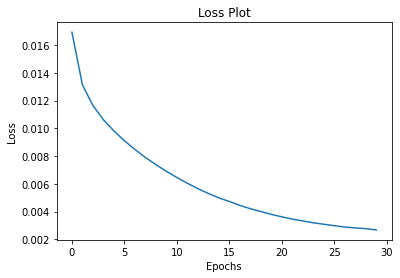

In [ ]:
plt.plot(lossValues_Graph)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

TESTING/VALIDATING OF THE CAPTIONS FOR IMAGES 

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((generateTensor_maxLen, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(displayImage(image)[0], 0)
    img_tensor_val = main_FeatureModel(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(generateTensor_maxLen):
        predictions, hidden, Bahdanau_AttnWeights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(Bahdanau_AttnWeights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> the surfer is riding on a wave in the ocean <end>
Prediction Caption: man surfing in the ocean <end>


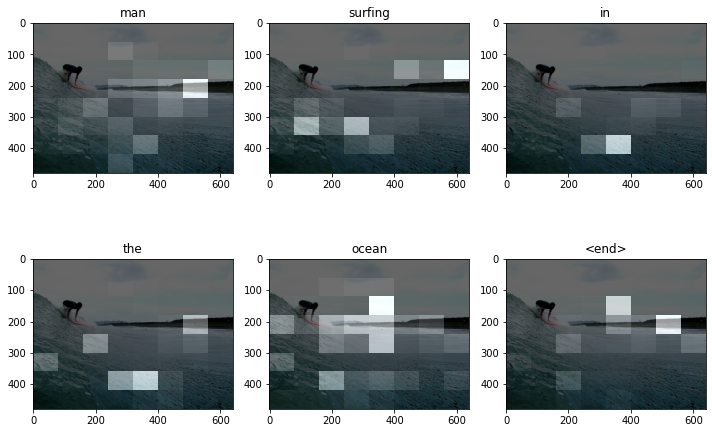

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(validation_Images))
image = validation_Images[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in validation_Captions[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

**METRIC 1 - COMPUTING BLEU SCORES**

Removing the #start and #end tokens from the real-caption.

In [ ]:
reference_caption = real_caption[8:]
reference_caption = reference_caption[:-6]
print(reference_caption)

the surfer is riding on a wave in the ocean


Generating the reference vector used to compute BLEU score.

In [ ]:
reference = reference_caption.split();
print("reference=", reference)

reference= ['the', 'surfer', 'is', 'riding', 'on', 'a', 'wave', 'in', 'the', 'ocean']


In [ ]:
print(result)

['man', 'surfing', 'in', 'the', 'ocean', '<end>']


Generating the hypothesis vector from the predicted caption. This vector is used to compute the BLEU score

In [ ]:
hypothesis = result
print("hypothesis=", hypothesis)

hypothesis= ['a', 'man', 'riding', 'skis', 'on', 'a', 'snowy', 'hill', '<end>']




*   NLTK provides the sentence_bleu() function for evaluating a candidate sentence against one or more reference sentences.





**NOTE : By default, the sentence_bleu() function calculates the cumulative 4-gram BLEU score, also called BLEU-4.**

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print("BLEU SCORE=",BLEUscore)

BLEU SCORE= 0.4042892997911646


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores**

In [ ]:
BLEU_4 = sentence_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU SCORE=",BLEU_4)

BLEU SCORE= 0.5773502691896257


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**INDUVIDUAL N-GRAM SCORES**

*   An individual N-gram score is the evaluation of just matching grams of a specific order, such as single words (1-gram) or word pairs (2-gram or bigram).
* The weights are specified as a tuple where each index refers to the gram order. 
* To calculate the BLEU score only for 1-gram matches, we specify a weight of 1 for 1-gram and 0 for 2, 3 and 4 (1, 0, 0, 0). For example:

In [ ]:
print('INDUVIDUAL N-GRAM SCORE RESULTS')
print('Individual 1-gram: %f' % sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0, 0, 0, 1)))

INDUVIDUAL N-GRAM SCORE RESULTS
Individual 1-gram: 0.111111
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 1.000000


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**CUMMULATIVE N-GRAM SCORES**

* Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.
* The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). 
* The 2-gram weights assign a 50% to each of 1-gram and 2-gram.
* The 3-gram weights are 33% for each of the 1, 2 and 3-gram scores.

In [ ]:
print('CUMMULATIVE N-GRAM SCORE RESULTS')
print('BLEU-1:')
print('Cumulative 1-gram: %f' % sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0)))
print('')
print('BLEU-2:')
print('Cumulative 2-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0.5, 0.5, 0, 0)))
print('')
print('BLEU-3:')
print('Cumulative 3-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0.33, 0.33, 0.33, 0)))
print('')
print('BLEU-4:')
print('Cumulative 4-gram: %f' % sentence_bleu(reference, hypothesis, weights=(0.25, 0.25, 0.25, 0.25)))

CUMMULATIVE N-GRAM SCORE RESULTS
BLEU-1:
Cumulative 1-gram: 0.111111

BLEU-2:
Cumulative 2-gram: 0.333333

BLEU-3:
Cumulative 3-gram: 0.484284

BLEU-4:
Cumulative 4-gram: 0.577350


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**WER**

In [ ]:
def wer_score(hyp, ref, print_matrix=False):
  N = len(hyp)
  M = len(ref)
  L = np.zeros((N,M))
  for i in range(0, N):
    for j in range(0, M):
      if min(i,j) == 0:
        L[i,j] = max(i,j)
      else:
        deletion = L[i-1,j] + 1
        insertion = L[i,j-1] + 1
        sub = 1 if hyp[i] != ref[j] else 0
        substitution = L[i-1,j-1] + sub
        L[i,j] = min(deletion, min(insertion, substitution))
        # print("{} - {}: del {} ins {} sub {} s {}".format(hyp[i], ref[j], deletion, insertion, substitution, sub))
  if print_matrix:
    print("WER matrix ({}x{}): ".format(N, M))
    print(L)
  return int(L[N-1, M-1])


In [ ]:
wer_score(hypothesis, reference, print_matrix=True)

WER matrix (9x10): 
[[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [1. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [2. 2. 2. 2. 3. 4. 5. 6. 7. 8.]
 [3. 3. 3. 3. 3. 4. 5. 6. 7. 8.]
 [4. 4. 4. 4. 3. 4. 5. 6. 7. 8.]
 [5. 5. 5. 5. 4. 3. 4. 5. 6. 7.]
 [6. 6. 6. 6. 5. 4. 4. 5. 6. 7.]
 [7. 7. 7. 7. 6. 5. 5. 5. 6. 7.]
 [8. 8. 8. 8. 7. 6. 6. 6. 6. 7.]]


7

**GLEU**

In [ ]:
import nltk.translate.gleu_score as gleu

GLEU-n

In GLEU-n, n-gram scores can be obtained in both sentence and corpus calculations and they're indicated by min_len and max_len parameters.

* min_len: minimum order of n-grams it should extract
* max_len: maximum order of n-grams it should extract

In [ ]:
score_1to4grams = gleu.sentence_gleu([reference], hypothesis, min_len=1, max_len=4)
score_1to2grams = gleu.sentence_gleu([reference], hypothesis, min_len=1, max_len=2)
print("1 to 4 grams: {}".format(score_1to4grams))
print("1 to 2 grams: {}".format(score_1to2grams))

1 to 4 grams: 0.11764705882352941
1 to 2 grams: 0.21052631578947367
